In [62]:
import tensorflow as tf
import numpy as np
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import matplotlib.patches as patches
from tensorflow.keras.utils import plot_model

In [126]:
def read_image_tfds(image, label):
  xmin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  ymin = tf.random.uniform((), 0, 48, dtype=tf.int32)
  image = tf.reshape(image, (28, 28, 1))
  image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
  image = tf.cast(image, tf.float32) / 255.0
  xmin = tf.cast(xmin, tf.float32)
  ymin = tf.cast(ymin, tf.float32)
  xmax = (xmin + 28) / 75
  ymax = (ymin + 28) / 75
  xmin /= 75
  ymin /= 75

  return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])

In [127]:
BATCH_SIZE = 64
train = tfds.load('mnist', split="train", as_supervised=True, try_gcs=True)
train_dataset = train.map(read_image_tfds)\
  .shuffle(1024)\
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

valid = tfds.load('mnist', split='test', as_supervised=True, try_gcs=True)
valid_dataset = valid.map(read_image_tfds, num_parallel_calls=16).batch(BATCH_SIZE)

In [133]:
sample = next(iter(train_dataset))
box = sample[1][1][0]*75
box

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([30., 32., 58., 60.], dtype=float32)>

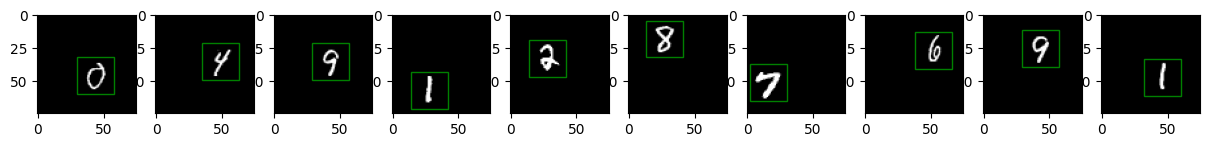

In [134]:
fig, ax = plt.subplots(1, 10, figsize=(15, 7))
for a, img, box in zip(ax, sample[0], sample[1][1]):
  box = box * 75
  width = box[2] - box[0]
  height = box[3] - box[1]
  a.imshow(img, cmap="gray")
  rect = patches.Rectangle((box[0], box[1]), width, height, linewidth=1, edgecolor='g', facecolor="none")
  a.add_patch(rect)


In [135]:
inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
x = tf.keras.layers.Conv2D(16, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.AveragePooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.AveragePooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.AveragePooling2D((2, 2))(x)

flat = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(128, activation="relu")(flat)

clf_output = tf.keras.layers.Dense(10, activation="softmax", name="classifier")(dense)
box_output = tf.keras.layers.Dense(4, name="bounding_box")(dense)

model = tf.keras.Model(inputs=inputs, outputs=[clf_output, box_output])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 73, 73, 16)           160       ['input_10[0][0]']            
                                                                                                  
 average_pooling2d_35 (Aver  (None, 36, 36, 16)           0         ['conv2d_36[0][0]']           
 agePooling2D)                                                                                    
                                                                                                  
 conv2d_37 (Conv2D)          (None, 34, 34, 32)           4640      ['average_pooling2d_35[0

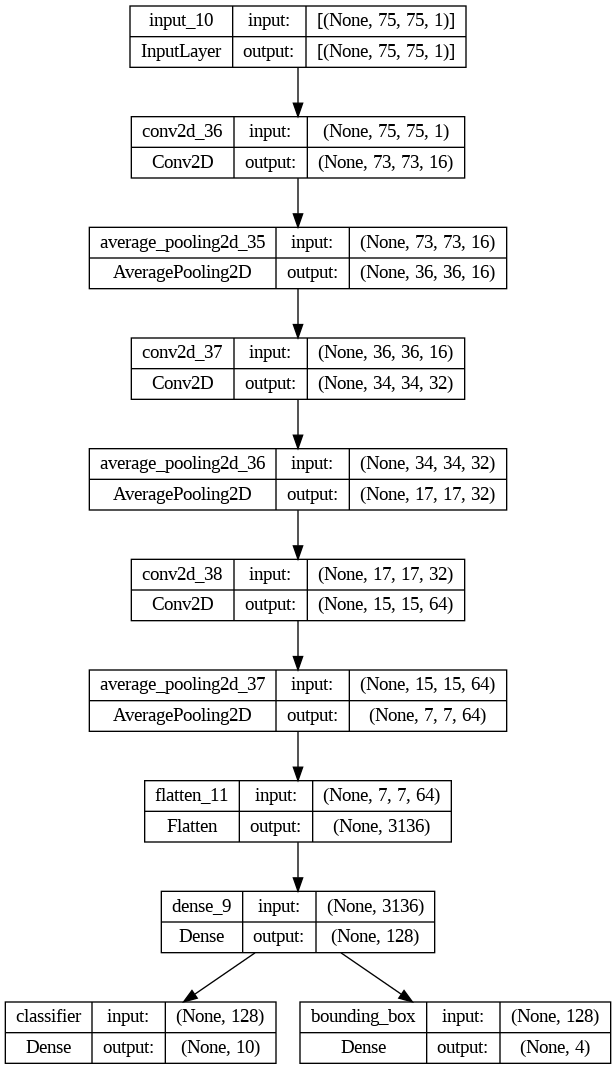

In [136]:
plot_model(model, show_shapes=True)

In [137]:
model.compile(loss={'classifier':'categorical_crossentropy',
                         'bounding_box':'mse'},
              optimizer=tf.keras.optimizers.Adam(),
              metrics={'classifier':'accuracy',
                       'bounding_box':'mse'})

In [138]:
EPOCHS = 45

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=valid_dataset)

Epoch 1/45
938/938 [==============================] - 23s 20ms/step - loss: 0.9003 - classifier_loss: 0.8847 - bounding_box_loss: 0.0157 - classifier_accuracy: 0.6937 - bounding_box_mse: 0.0157 - val_loss: 0.3619 - val_classifier_loss: 0.3503 - val_bounding_box_loss: 0.0116 - val_classifier_accuracy: 0.8890 - val_bounding_box_mse: 0.0116
Epoch 2/45
938/938 [==============================] - 14s 15ms/step - loss: 0.2432 - classifier_loss: 0.2366 - bounding_box_loss: 0.0066 - classifier_accuracy: 0.9290 - bounding_box_mse: 0.0066 - val_loss: 0.2052 - val_classifier_loss: 0.2001 - val_bounding_box_loss: 0.0052 - val_classifier_accuracy: 0.9365 - val_bounding_box_mse: 0.0052
Epoch 3/45
938/938 [==============================] - 14s 14ms/step - loss: 0.1747 - classifier_loss: 0.1709 - bounding_box_loss: 0.0038 - classifier_accuracy: 0.9482 - bounding_box_mse: 0.0038 - val_loss: 0.1540 - val_classifier_loss: 0.1512 - val_bounding_box_loss: 0.0029 - val_classifier_accuracy: 0.9540 - val_bound

Text(0.5, 1.0, 'classifier accuracy')

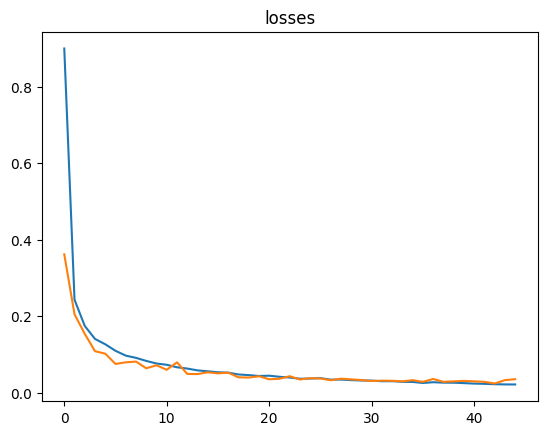

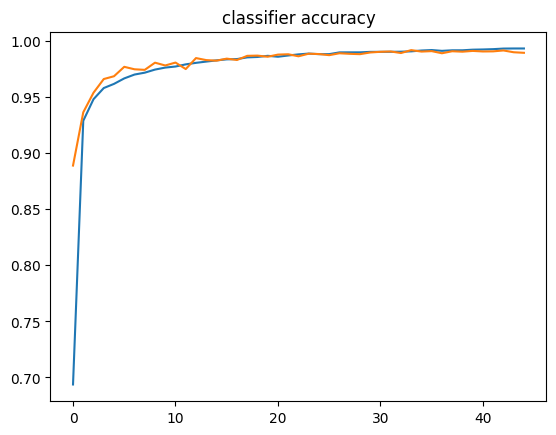